In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname))
        break
    

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#whether to see if file is all-right

/kaggle/input/follicular-adenoma-sample/1028034_files/20.0
/kaggle/input/follicular-adenoma-sample/1028123_files/20.0
/kaggle/input/follicular-adenoma-sample/1028041_files/20.0
/kaggle/input/follicular-adenoma-sample/1028031_files/20.0
/kaggle/input/follicular-adenoma-sample/1028032_files/20.0
/kaggle/input/follicular-adenoma-sample/1028040_files/20.0
/kaggle/input/follicular-adenoma-sample/1028035_files/20.0
/kaggle/input/follicular-adenoma-sample/1028120_files/20.0
/kaggle/input/follicular-adenoma-sample/1028029_files/20.0
/kaggle/input/follicular-adenoma-sample/1028124_files/20.0
/kaggle/input/follicular-adenoma-sample/1028115_files/20.0
/kaggle/input/follicular-adenoma-sample/1028114_files/20.0
/kaggle/input/follicular-adenoma-sample/1028043_files/20.0
/kaggle/input/follicular-adenoma-sample/1028125_files/20.0
/kaggle/input/follicular-adenoma-sample/1028033_files/20.0
/kaggle/input/follicular-adenoma-sample/1028130_files/20.0
/kaggle/input/follicular-adenoma-sample/1028132_files/20

All of the process is about:

1. preprocessing of the images <- been adopted in deeppath code
1. dataset object defining
1. data loader defining
1. train-test split, and training
1. valid data showing

ValueError: high <= 0

<Figure size 1500x600 with 0 Axes>

In [2]:
#version 3
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for dir_name in os.listdir(root_dir):
            print(f"Found directory: {dir_name}")  # Diagnostic print
            if dir_name.endswith('_files'):
                number_dir_path = os.path.join(root_dir, dir_name)
                dir_path = os.path.join(number_dir_path, '20.0')  # Navigate to the '20.0' subdirectory
                label = 0 if int(dir_name.split('_')[0]) < 1028100 else 1  # Determine label based on directory name
                for img_name in os.listdir(dir_path):
                    if img_name.endswith('.jpeg'):  # Look for .jpeg files
                        img_path = os.path.join(dir_path, img_name)
                        self.samples.append((img_path, label))

        print(f"Total samples loaded: {len(self.samples)}")  # Diagnostic print

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [3]:
def prune_image_rows_cols(img, thr=0.001):
    # delete empty columns
    for l in reversed(range(img.shape[1])):
        if (np.sum(img[:, l]) / float(img.shape[0])) < thr:
            img = np.delete(img, l, 1)
    # delete empty rows
    for l in reversed(range(img.shape[0])):
        if (np.sum(img[l, :]) / float(img.shape[1])) < thr:
            img = np.delete(img, l, 0)
    return img

In [4]:
def prune_image(img, thr=0.001):
    #delete empty columns
    for l in reversed(range(img.shape[1])):
        if (np.sum(img[:,l])/float(img.shape[0]))<thr:
            img = np.delete(img, l, 1)
    #delete empty rows
    for l in reversed(range(img.shape[0])):
        if (np.sum(img[l,:])/float(img.shape[1]))<thr:
            img = np.delete(img, l, 1)

In [5]:
def prune_scale_image(img_path: str, out_dir: str, size: int = 512) -> None:
    img = np.array(Image.open(img_path))
    img = prune_image_rows_cols(img)
    mask = np.sum(img[..., :3], axis=2) == 0
    img[mask, :] = 255
    img = Image.fromarray(img)
    img.thumbnail((size, size))
    img.save(os.path.join(out_dir, os.path.basename(img_path)))

In [8]:
dataset_img = '/kaggle/input/follicular-adenoma-sample'

In [6]:
def prune_scale(img_path:str, out_dir:str, size_int=512) -> None:
    img = np.array(Image.open(img_path))
    img = prune_image(img)
    mask = np.sum(img[...,:3], axis=2) ==0
    img[mask,:] = 255
    img = Image.fromarray(img)
    img.thumbnail((size,size))
    img.save(os.path.join(out_dir, os.path.basename(img_path)))

In [9]:

import glob
from PIL import Image
from tqdm.auto import tqdm
from joblib import Parallel, delayed

! mkdir -p train_thumbnails
! rm -f train_thumbnails/*.png

ls = glob.glob(os.path.join(dataset_img,'20.0' ,'*.jpeg'))
print(f"found images: {len(ls)}")

# for p_img in tqdm(ls):
#     prune_scale_image(p_img, "./train_thumbnails")
    
# _= Parallel(n_jobs=4)(
#     delayed(prune_scale_image)(p_img, "./train_thumbnails") for p_img in tqdm(ls)
# )
# ls = glob.glob(os.path.join("./train_thumbnails", '*.png'))
# print(f"found images: {len(ls)}")

found images: 0


0it [00:00, ?it/s]

found images: 0


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Transformation for displaying images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize for display purposes
    transforms.ToTensor()
])

# Initialize dataset
dataset = TumorDataset(root_dir='/kaggle/input/follicular-adenoma-sample', transform=transform)


Found directory: 1028034_files
Found directory: 1028123_files
Found directory: 1028041_files
Found directory: 1028031_files
Found directory: 1028032_files
Found directory: 1028040_files
Found directory: 1028035_files
Found directory: 1028120_files
Found directory: 1028029_files
Found directory: 1028124_files
Found directory: 1028115_files
Found directory: 1028114_files
Found directory: 1028043_files
Found directory: 1028125_files
Found directory: 1028033_files
Found directory: 1028130_files
Found directory: 1028132_files
Found directory: 1028036_files
Found directory: 1028111_files
Found directory: 1028118_files
Total samples loaded: 42173


In [23]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images for visualization
    transforms.ToTensor()
])

# Initialize the dataset
dataset = TumorDataset(root_dir='/kaggle/input/follicular-adenoma-sample', transform=transform)


Found directory: 1028034_files
Found directory: 1028123_files
Found directory: 1028041_files
Found directory: 1028031_files
Found directory: 1028032_files
Found directory: 1028040_files
Found directory: 1028035_files
Found directory: 1028120_files
Found directory: 1028029_files
Found directory: 1028124_files
Found directory: 1028115_files
Found directory: 1028114_files
Found directory: 1028043_files
Found directory: 1028125_files
Found directory: 1028033_files
Found directory: 1028130_files
Found directory: 1028132_files
Found directory: 1028036_files
Found directory: 1028111_files
Found directory: 1028118_files
Total samples loaded: 42173


In [24]:
len(dataset)

42173

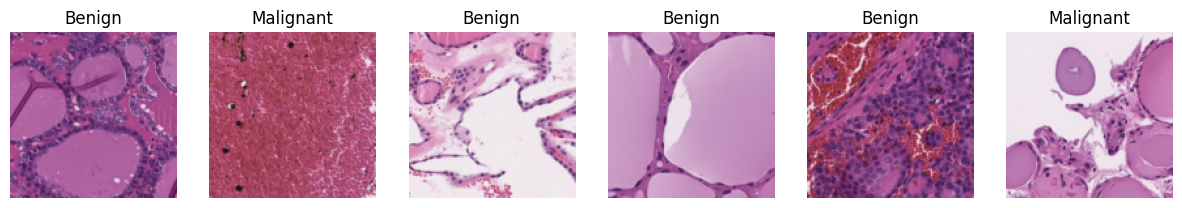

In [37]:

# Function to display images
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')

def show_sample_images(dataset, num_images=6):
    fig = plt.figure(figsize=(15, 6))
    for i in range(num_images):
        idx = np.random.randint(0, len(dataset))
        img, label = dataset[idx]
        label_str = 'Malignant' if label == 0 else 'Benign'
        ax = fig.add_subplot(1, num_images, i + 1, xticks=[], yticks=[])
        imshow(img)
        ax.set_title(label_str)

if len(dataset) > 0:
    show_sample_images(dataset)
else:
    print("No samples loaded, please check the dataset paths and file structure.")


In [11]:

def imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')

def show_sample_images(dataset, num_images=6):
    fig = plt.figure(figsize=(15, 6))
    for i in range(num_images):
        idx = np.random.randint(0, len(dataset))
        img, label = dataset[idx]
        label_str = 'Malignant' if label == 0 else 'Benign'
        ax = fig.add_subplot(1, num_images, i + 1, xticks=[], yticks=[])
        imshow(img)
        ax.set_title(label_str)

show_sample_images(dataset)


ValueError: high <= 0

<Figure size 1500x600 with 0 Axes>

# Step 2: Model Design

In [33]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Adjusted for image size after pooling
        self.fc2 = nn.Linear(128, 2)  # Assuming 2 classes

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # All dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


# Step 3: Training

In [28]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to simplify the problem
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

dataset = TumorDataset(root_dir='follicular-adenoma-sample', transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop (simplified)
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}")

print('Finished Training')


FileNotFoundError: [Errno 2] No such file or directory: 'follicular-adenoma-sample'

In [35]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class TumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for dir_name in os.listdir(root_dir):
            if dir_name.endswith('_files'):
                number_dir_path = os.path.join(root_dir, dir_name)
                dir_path = os.path.join(number_dir_path, '20.0')  # Access the '20.0' subdirectory
                label = 0 if int(dir_name.split('_')[0]) < 1028100 else 1
                for img_name in os.listdir(dir_path):
                    if img_name.endswith('.jpeg'):  # Look specifically for .jpeg files
                        img_path = os.path.join(dir_path, img_name)
                        self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images for visualization
    transforms.ToTensor()
])

# Initialize the dataset
dataset = TumorDataset(root_dir='/kaggle/input/follicular-adenoma-sample', transform=transform)


# Initialize dataset and dataloader
# dataset = TumorDataset(root_dir='follicular-adenoma-sample', transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Update the input features for fc1 based on the calculation above
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Adjusted to the correct size
        self.fc2 = nn.Linear(128, 2)  # Assuming 2 classes: malignant, benign

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64 * 32 * 32)  # Update this line as well to match the new size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}")

print('Finished Training')


In [ ]:
# Assuming test_loader is defined, similar to dataloader for training
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0
with torch.no_grad():  # For evaluation, we don't need gradient computation
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test dataset: {accuracy:.2f}%')
